In [151]:
from prettytable import PrettyTable, MSWORD_FRIENDLY

import numpy as np

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
import pandas as pd

from importlib import reload

import testconf
import bnnc

In [157]:
def load_model_predictions(modelname:str, generation_method:str, fixed_bits:int):
    preds = np.load(testconf.prediction_path(modelname, generation_method, fixed_bits))["arr_0"]

    _, test_data = testconf.get_data(modelname)
    targets = np.array(test_data.targets)[:preds.shape[1]]

    cdata = (*bnnc.uncertainty.analyze_predictions(preds, targets), preds)
    cacc = bnnc.uncertainty.accuracy(cdata[0])
    cece, cuce = bnnc.uncertainty.calibration_errors(cdata[0])

    preds = np.load(testconf.baseline_path(modelname))["arr_0"]

    pydata = (*bnnc.uncertainty.analyze_predictions(preds, targets), preds)
    pyacc = bnnc.uncertainty.accuracy(pydata[0])
    pyece, pyuce = bnnc.uncertainty.calibration_errors(pydata[0])

    match_ratio, diff_mask = bnnc.uncertainty.match_ratio(cdata[0], pydata[0])

    table = PrettyTable()
    table.set_style(MSWORD_FRIENDLY)
    table.field_names = [f"{modelname}-{generation_method}-{fixed_bits}", "Accuracy %", "ECE %", "UCE %"]
    table.add_rows([
        ["Python", f"{100 * pyacc:.3f}", f"{100 * pyece:.3f}", f"{100 * pyuce:.3f}"],
        ["C", f"{100 * cacc:.3f}", f"{100 * cece:.3f}", f"{100 * cuce:.3f}"]
    ])
    print(table)

    print(f"Matching preditions {match_ratio:.5}")

    return cdata, pydata, diff_mask

In [158]:
d = {}
d["RU"] = load_model_predictions("RESNET", "uniform", 10)
d["BU"] = load_model_predictions("B2N2", "uniform", 10)
d["LU"] = load_model_predictions("LENET", "uniform", 10)

d["RG"] = load_model_predictions("RESNET", "gaussian", 10)
d["BG"] = load_model_predictions("B2N2", "gaussian", 10)
d["LG"] = load_model_predictions("LENET", "gaussian", 10)

Files already downloaded and verified
| RESNET-uniform-10 | Accuracy % | ECE % | UCE % |
|       Python      |   81.010   | 1.609 | 2.239 |
|         C         |   79.670   | 0.995 | 2.946 |
Matching preditions 0.933
Files already downloaded and verified
| B2N2-uniform-10 | Accuracy % | ECE % | UCE % |
|      Python     |   75.770   | 1.693 | 2.721 |
|        C        |   75.940   | 0.620 | 4.584 |
Matching preditions 0.9666
Files already downloaded and verified
| LENET-uniform-10 | Accuracy % | ECE % | UCE % |
|      Python      |   62.610   | 2.655 | 4.089 |
|        C         |   62.230   | 1.494 | 5.434 |
Matching preditions 0.9539
Files already downloaded and verified
| RESNET-gaussian-10 | Accuracy % | ECE % | UCE % |
|       Python       |   81.010   | 1.609 | 2.239 |
|         C          |   79.750   | 0.880 | 3.052 |
Matching preditions 0.9377
Files already downloaded and verified
| B2N2-gaussian-10 | Accuracy % | ECE % | UCE % |
|      Python      |   75.770   | 1.693 | 2.721

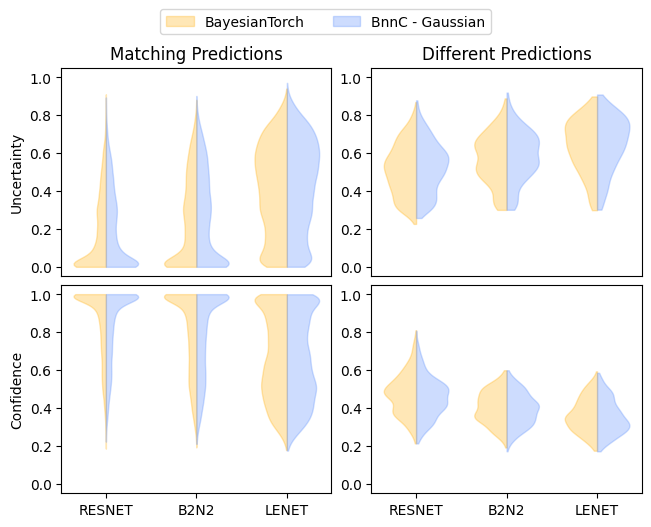

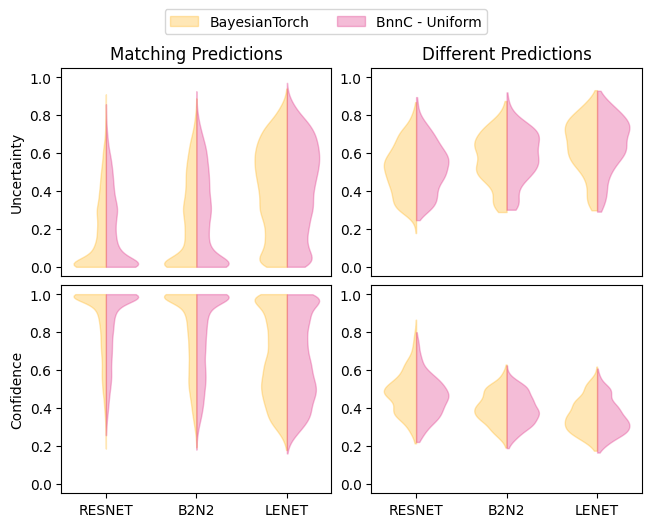

In [159]:
reload(bnnc.plot)

def probplots(d, names, tag, second_color):
    fig = pl.figure(constrained_layout=True)
    axes = fig.subplots(2,2)

    t = 0.7

    for i, l in enumerate(names):
        cdata, pydata, diff_mask = d[l]
        bnnc.plot.same_violin_plot(pydata, cdata, diff_mask, [axes[0][0], axes[1][0]], 1 + i*t, second_color)
        bnnc.plot.diff_violin_plot(pydata, cdata, diff_mask, [axes[0][1], axes[1][1]], 1 + i*t, second_color)

    axes[0][0].set_title("Matching Predictions")
    axes[0][1].set_title("Different Predictions")

    axes[0][0].set_xticks([])
    axes[0][1].set_xticks([])
    axes[0][1].set_ylabel("")
    axes[1][0].set_xticks([1, 1 + 1*t, 1 + 2*t], ["RESNET", "B2N2", "LENET"])
    axes[1][1].set_xticks([1, 1 + 1*t, 1 + 2*t], ["RESNET", "B2N2", "LENET"])
    axes[1][1].set_ylabel("")

    fig.legend(
        ["BayesianTorch", f"BnnC - {tag}"],
        bbox_to_anchor=(0.5, 1),
        loc='lower center', ncols=2,
    )

    fsize = fig.get_size_inches()
    fig.set_size_inches(fsize * np.array([1,1]))

    return fig

probplots(d, ["RG", "BG", "LG"], "Gaussian", bnnc.plot.COLOR_1).savefig("dist_gauss.pdf")
pl.show()

probplots(d, ["RU", "BU", "LU"], "Uniform", bnnc.plot.COLOR_3).savefig("dist_unif.pdf")
pl.show()


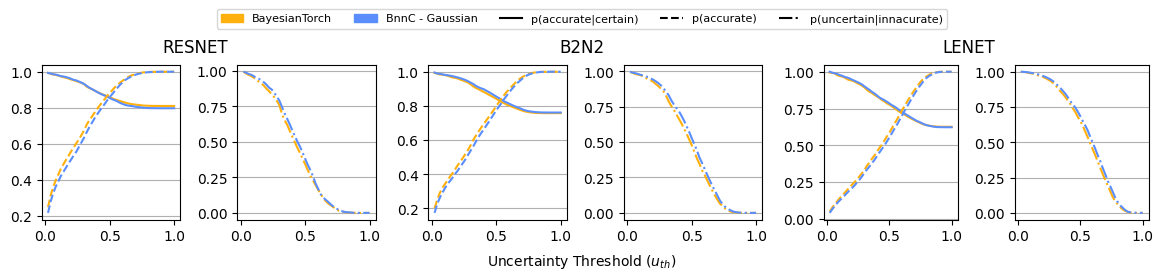

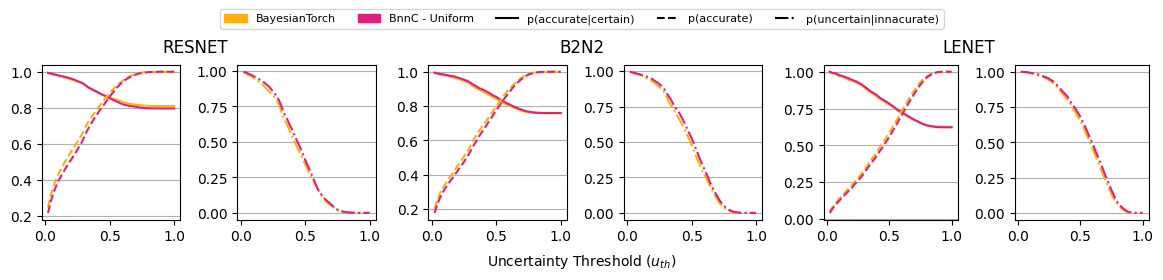

In [161]:
reload(bnnc.plot)

def uncert_plots(d, names, tag, second_color):
    fig = pl.figure(constrained_layout=True)

    subfigs = fig.subfigures(1, 3)

    axes = subfigs[0].subplots(1, 2)
    cdata, pydata, diff_mask = d[names[0]]
    bnnc.plot.acc_cert_unc_inc_plot_double((
        bnnc.plot.acc_cert_unc_inn_data(pydata[0]),
        bnnc.plot.acc_cert_unc_inn_data(cdata[0])
    ), axes=axes, second_color=second_color)
    subfigs[0].suptitle("RESNET")

    axes = subfigs[1].subplots(1, 2)
    cdata, pydata, diff_mask = d[names[1]]
    bnnc.plot.acc_cert_unc_inc_plot_double((
        bnnc.plot.acc_cert_unc_inn_data(pydata[0]),
        bnnc.plot.acc_cert_unc_inn_data(cdata[0])
    ), axes=axes, second_color=second_color)
    subfigs[1].suptitle("B2N2")


    axes = subfigs[2].subplots(1, 2)
    cdata, pydata, diff_mask = d[names[2]]
    bnnc.plot.acc_cert_unc_inc_plot_double((
        bnnc.plot.acc_cert_unc_inn_data(pydata[0]),
        bnnc.plot.acc_cert_unc_inn_data(cdata[0])
    ), axes=axes, second_color=second_color)
    subfigs[2].suptitle("LENET")

    fig.supxlabel(r"Uncertainty Threshold ($u_{th}$)", fontsize=10)

    fig.legend(
        handles=[
            mpatches.Patch(color=bnnc.plot.COLOR_2, label='BayesianTorch'),
            mpatches.Patch(color=second_color, label=f"BnnC - {tag}"),
            mlines.Line2D([], [], color='black', label='p(accurate|certain)'),
            mlines.Line2D([], [], linestyle='--', color='black', label='p(accurate)'),
            mlines.Line2D([], [], linestyle='-.', color='black', label='p(uncertain|innacurate)'),
        ],
        bbox_to_anchor=(0.5,1),
        loc='lower center', ncols=5,
        fontsize=8
    )

    w, h = fig.get_size_inches()
    fig.set_size_inches((1.8*w, 0.5*h))
    return fig

uncert_plots(d, ["RG", "BG", "LG"], "Gaussian", bnnc.plot.COLOR_1).savefig("probs_gauss.pdf")
pl.show()

uncert_plots(d, ["RU", "BU", "LU"], "Uniform",  bnnc.plot.COLOR_3).savefig("probs_unif.pdf")
pl.show()